# **Rezbin AI Model v2.0 Development**

We are fine-tuning a MobileNetV2 model for a multi-class image classification of the TrashNet dataset.

In [22]:
import torch
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn, optim
from torchvision.transforms import v2
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [23]:
dataset_path = Path('../dataset-resized/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

In [24]:
idx_labels

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [25]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

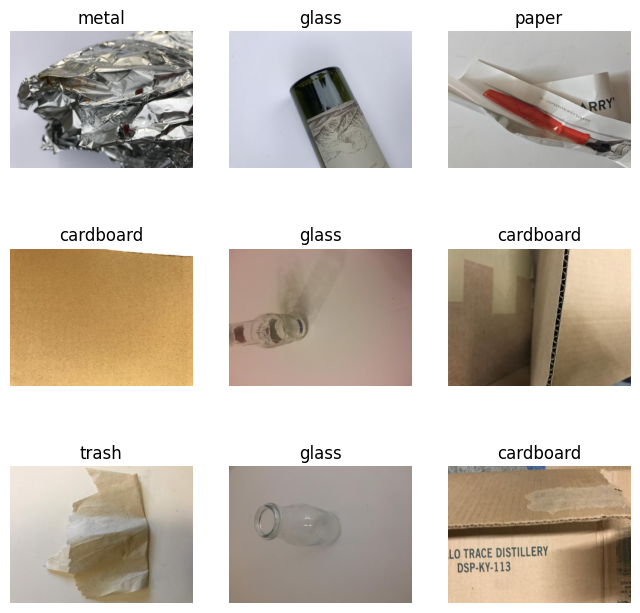

In [26]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [27]:
transform = v2.Compose([
    # augmentation steps from paper
    v2.RandomAffine(
        degrees=[-5, 5],
        translate=(0.1, 0.1),
        fill=0,
        shear=20            
    ),
    v2.RandomHorizontalFlip(p=0.5),
    
    # Transform to image
    v2.Resize((384,512)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [28]:
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702837].


Feature batch shape: torch.Size([64, 3, 384, 512])
Labels batch shape: torch.Size([64])


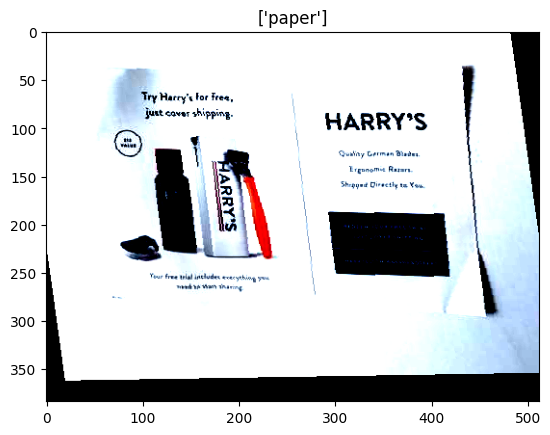

In [29]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [30]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(idx_labels))
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

c:\Users\admin\Desktop\ai-model-v2.0\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\Desktop\ai-model-v2.0\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [31]:
def compute_accuracy(preds, labels):
    _, pred_labels = preds.max(1)
    return (pred_labels == labels).sum().item() / labels.size(0)

In [32]:
def train_one_epoch(epoch, model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += acc * inputs.size(0)
        total += inputs.size(0)
        
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            correct += acc * inputs.size(0)
            total += inputs.size(0)

    return total_loss / total, correct / total

In [33]:
# For logging best results
MODEL_LOG = Path(f"../models/logs/run_{datetime.now():%Y%m%d_%H%M%S}")
MODEL_LOG.mkdir(parents=True, exist_ok=True)
CSV_LOG_PATH = MODEL_LOG / "training_log.csv"

log_df = pd.DataFrame(columns=['epoch', 'phase', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr'])

In [ ]:
best_val_acc = 0.0

print("--- Preparing for Phase 1: Freezing & Preparing Hyperparameters ---")
print("🔒 PHASE 1: Training classifier head only")

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classifier's parameters
for param in model.classifier.parameters():
    param.requires_grad = True

# Define hyperparams
optimizer_p1 = optim.AdamW(model.classifier.parameters(), lr=3e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler_p1 = ReduceLROnPlateau(optimizer_p1, mode='min', patience=3)

# Ensure that the classifier head is mostly trained
# And avoid too much training time for other layers
EPOCHS_FROZEN = 50  # Train classifier only (base frozen)
EPOCHS_TOTAL = 20 + EPOCHS_FROZEN  # Fine-tune base (unfrozen) after

# This is a hyperparameter to ensure that
# the model won't overfit
best_val_loss_p1 = float('inf')
best_val_acc_p1 = 0.0
PATIENCE = 5
trigger_times_p1 = 0

for epoch in range(EPOCHS_FROZEN):
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer_p1, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler_p1.step(val_loss)
    
    lr = optimizer_p1.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase1', train_loss, train_acc, val_loss, val_acc, lr]
    # Trigger if it performs worse
    if val_loss < best_val_loss_p1:
        best_val_loss_p1 = val_loss
        trigger_times_p1 = 0
    else:
        trigger_times_p1 += 1
        if trigger_times_p1 >= PATIENCE:
            print("Early stopping PHASE 1")
            break
    
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p1_e{epoch+1}_best_model.pth")
    
    print(f"P1: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2} | Patience: {trigger_times_p1} / {PATIENCE} | LR: {lr}")

# --- Phase 2: Fine-tuning specific feature layers and classifier ---
print("\n--- Preparing for Phase 2: Unfreezing specific feature layers ---")

# Ensure all layers are still frozen from Phase 1, then unfreeze selectively.
for param in model.parameters():
    param.requires_grad = False

# Ensure classifier is still unfrozen (important if you didn't save/load state_dict)
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze layers from features 10 to 18
for i, module in enumerate(model.features.children()):
    if 10 <= i <= 18: 
        for param in module.parameters():
            param.requires_grad = True

# Get unfrozen params
trainable_params_p2 = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params_p2.append(param)
        print(name)

# Re-create the optimizer for Phase 2 (only for unfrozen params)
optimizer_p2 = optim.AdamW(trainable_params_p2, lr=1e-5, weight_decay=1e-5)
scheduler_p2 = ReduceLROnPlateau(optimizer_p2, mode='min', patience=3)

best_val_acc_p2 = best_val_acc_p1 # Start with the best from Phase 1
best_val_loss_p2 = best_val_loss_p1 # Start with the best from Phase 1
trigger_times_p2 = 0

print("\n🔓 Phase 2: Fine-tuning specific feature layers and classifier")
for epoch in range(EPOCHS_FROZEN, EPOCHS_TOTAL):
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer_p2, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler_p2.step(val_loss)
    
    lr = optimizer_p2.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase2', train_loss, train_acc, val_loss, val_acc, lr]

    # Early stopping logic for Phase 2
    if val_loss < best_val_loss_p2:
        best_val_loss_p2 = val_loss
        trigger_times_p2 = 0
    else:
        trigger_times_p2 += 1
        if trigger_times_p2 >= PATIENCE:
            print("Early stopping Phase 2!")
            break
    
    if val_acc > best_val_acc_p2:
        best_val_acc_p2 = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p2_e{epoch+1}_best_model.pth")

    print(f"P2: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2f} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2f} | Patience: {trigger_times_p2} / {PATIENCE} | LR: {lr}")

log_df.to_csv(CSV_LOG_PATH, index=False)
print(f"\n📑 Training complete. Best validation accuracy: {best_val_acc:.2%}")

--- Preparing for Phase 1: Freezing & Preparing Hyperparameters ---
🔒 PHASE 1: Training classifier head only


Epoch 1 [Train]:  16%|█▌        | 5/32 [03:19<15:59, 35.53s/it, acc=0.203, loss=1.78] 

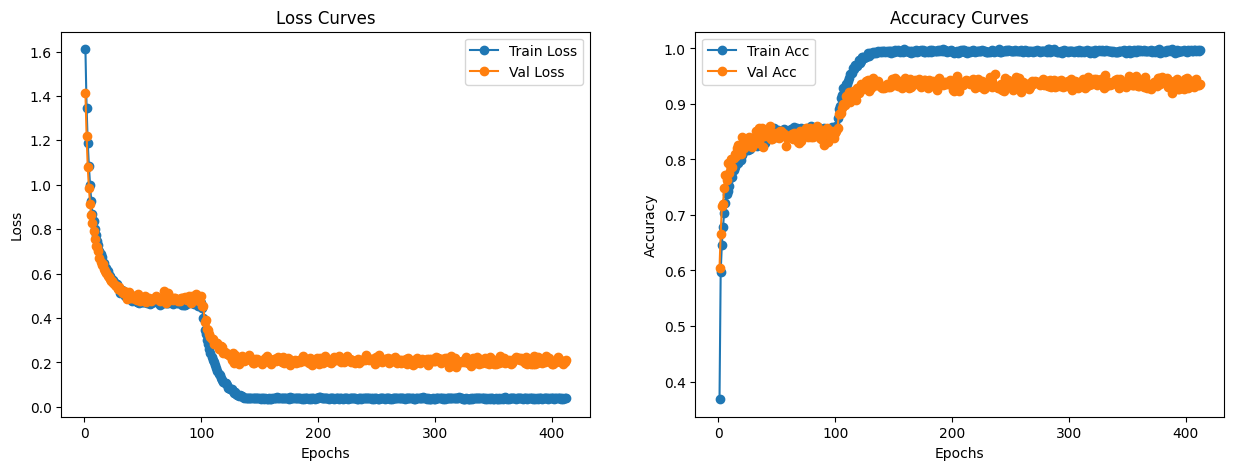

In [14]:
import matplotlib.pyplot as plt

# Assuming log_df contains your training logs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', marker='o')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
ax2.plot(log_df['epoch'], log_df['train_acc'], label='Train Acc', marker='o')
ax2.plot(log_df['epoch'], log_df['val_acc'], label='Val Acc', marker='o')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.savefig(MODEL_LOG / "output.jpg")
plt.show()